# Parte I: Producción de datos

Autores: Jordi Bolibar & Facundo Sapienza  
Traducción: Eduardo Villavicencio

Este cuaderno está dedicado a obtener todos los datos necesarios para entrenar los modelos de aprendizaje automático de este proyecto. Para ello, necesitamos datos climáticos, topográficos y de balance de masa de todos los glaciares en Southern Andes. La obtención de los datos climáticos y topográficos se procesa utilizando el [Modelo Global de Glaciares Abierto](https://oggm.org). 


Primero, importamos las dependencias y configuramos OGGM.

```{note}
Antes de ejecutar este cuaderno, asegúrate de que el núcleo de Jupyter (esquina superior izquierda del cuaderno) esté configurado para trabajar con el entorno `finse_modelling` de conda.
```


In [1]:
import oggm
oggm.__version__

'1.6.0'

Importamos todas las dependencias necesarias para obtener los datos con OGGM y para procesarlos posteriormente. Usamos multiprocesamiento con OGGM para acelerar las cosas.

In [2]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta


In [3]:
pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-09-06 19:35:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-09-06 19:35:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-09-06 19:35:05: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-09-06 19:35:07: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-09-06 19:35:07: oggm.cfg: Multiprocessing switched ON after user settings.


Selecciona la ruta de OGGM donde deseas almacenar todos los datos.

- Está configurada para apuntar a la carpeta en la que estamos trabajando.

In [7]:
parent_path = os.getcwd () # Direccion del proyecto 

workspace_path = os.path.join(parent_path, 'OGGM_data_Finse')

if not os.path.exists(os.path.join(parent_path, 'Data')):
    os.mkdir(os.path.join(parent_path, 'Data'))

if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)

cfg.PATHS['working_dir'] = workspace_path

ejecutan en un entorno de OGGM para realizar tareas específicas. OGGM se basa en los `gdir`, que son Directorios de Glaciares. Estos objetos de Python representan glaciares individualmente y contienen toda la información necesaria para su simulación.

- Aquí declaramos todas las tareas de entidad personalizadas (que se utilizarán más adelante), ya que deben definirse antes de inicializar los directorios de glaciares. Esta tarea se encarga de obtener todos los datos topográficos de los `gdir`.

In [5]:
@entity_task(log)
def get_topo_predictors(gdir):
    """Mandatory docstring
    """
        
    training_data = {'zmed': 0.0,
                 'zmax': 0.0,
                 'zmin': 0.0,
                 'area': 0.0,
                 'slope': 0.0,
                 'lat': 0.0,
                 'lon': 0.0,
                 'icecap': 0.0,
                 'ID': ""
        }
    
    gl_shp = gdir.read_shapefile('outlines')
    
    training_data['zmed'] = float(gl_shp.Zmed.values[0])
    training_data['zmax'] = float(gl_shp.Zmax.values[0])
    training_data['zmin'] = float(gl_shp.Zmin.values[0])
    training_data['area'] = gdir.rgi_area_km2
    training_data['lat'] = gdir.cenlat
    training_data['lon'] = gdir.cenlon
    training_data['icecap'] = int(gdir.is_icecap)
    training_data['slope'] = float(gl_shp.Slope.values[0])
    training_data['ID'] = gdir.rgi_id
        
    return training_data

Descarga todos los datos de los glaciares en Low Latitudes (región RGI '16') utilizando el Inventario de Glaciares de Randolph (RGI v6). 

- Esto podría fallar si los datos ya han sido descargados (incluso parcialmente). Este proceso se lleva a cabo al inicializar los directorios de glaciares.

In [8]:
rgi_region = '16' #Low Latitudes
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2024-09-06 19:47:29: oggm.workflow: init_glacier_directories from prepro level 3 on 2939 glaciers.
2024-09-06 19:47:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2939 glaciers


## 1.1. Obtener datos de balance de masa geodésico de glaciares

Para entrenar nuestro modelo de aprendizaje automático, , necesitamos datos de referencia, en este caso el balance de masa geodésico. Para ello, obtenemos el balance de masa geodésico para todos los glaciares en Southern Andes a partir de [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z). La [OGGM Shop](https://docs.oggm.org/en/stable/shop.html)  fácilmente a una amplia gama de conjuntos de datos.

In [9]:
mb_df = utils.get_geodetic_mb_dataframe()
mb_df.drop(columns=['area', 'reg', 'is_cor'])
mb_df.index.names = ['rgi_id']
mb_df = mb_df.reset_index()

# We want to filer just the right region #def extract_region_id(name):
mb_df['region'] = mb_df.apply(lambda row: row.rgi_id.split('-')[1][:2], axis=1)
mb_df = mb_df[mb_df.region==rgi_region]
mb_df

,rgi_id,period,area,dmdtda,err_dmdtda,reg,is_cor,region
571233,RGI60-16.00001,2000-01-01_2010-01-01,98000.0,-0.0546,0.4090,16,False,16
571234,RGI60-16.00001,2000-01-01_2020-01-01,98000.0,-0.1955,0.2230,16,False,16
571235,RGI60-16.00001,2010-01-01_2020-01-01,98000.0,-0.3365,0.4209,16,False,16
571236,RGI60-16.00002,2000-01-01_2010-01-01,147000.0,-0.1198,0.3682,16,False,16
571237,RGI60-16.00002,2000-01-01_2020-01-01,147000.0,-0.1237,0.1904,16,False,16
...,...,...,...,...,...,...,...,...
580045,RGI60-16.02944,2000-01-01_2020-01-01,9337000.0,-0.1741,0.1351,16,False,16
580046,RGI60-16.02944,2010-01-01_2020-01-01,9337000.0,-0.3021,0.2548,16,False,16
580047,RGI60-16.02945,2000-01-01_2010-01-01,2526000.0,-0.4199,0.2688,16,False,16
580048,RGI60-16.02945,2000-01-01_2020-01-01,2526000.0,-0.4071,0.1517,16,False,16


Guardamos este conjunto de datos en un archivo CSV para usarlo más adelante.

In [10]:
mb_df.to_csv('Data/mb_df.csv')

## 1.2. Obtener datos topográficos de los glaciares

Ahora obtenemos los datos topográficos de todos los glaciares que se utilizarán en el entrenamiento.

In [11]:
# TODO: COMPUTE AVERAGE ICE THICKNESS PER GLACIER

Seleccionamos un glaciar como ejemplo para mostrar los datos disponibles.

In [ ]:
for i in range(2411,2481):
    gdir = gdirs[i] # Seleccionar

    glshp = gdir.read_shapefile('outlines')

    # Convertir a float
    CenLat = glshp['CenLat'].astype(float)
    CenLon = glshp['CenLon'].astype(float)

    # Graficar los puntos que cumplen la condición
    for lat, lon in zip(CenLat, CenLon):
        if -9.075< lat < -8.926:
            if  -77.77 < lon < -77.56:
                if i == 2437:
                    plt.scatter(CenLon, CenLat, color=f'r')
                else:
                    plt.scatter(CenLon, CenLat, color=f'black')

In [15]:
gdir = gdirs[2437] # Seleccionar un glaciar de arteson

glshp = gdir.read_shapefile('outlines')
glshp.O1Region.values[0]

'16'

In [16]:
dem_path = gdir.get_filepath('dem')

Mostramos la topografía el contornos del glaciar.

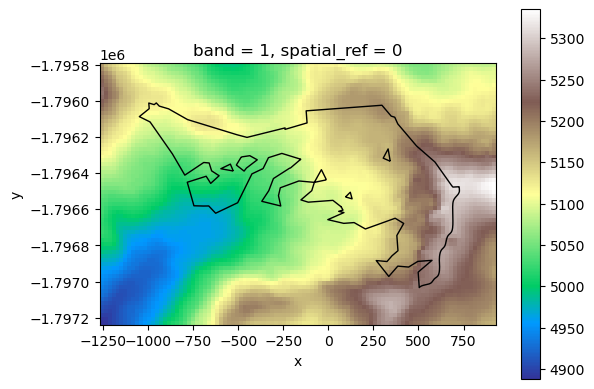

In [17]:
da = rioxarray.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

Para obtener las características topográficas para nuestro modelo de aprendizaje automático, utilizamos la funcion (get_topo_predictors) que declaramos previamente.  
Para ejecutar esto de manera más eficiente, lo paralelizamos utilizando la función como una entidad en OGGM.  
Los datos topográficos ya están disponibles en el Hub.  
Dado que esto es computacionalmente costoso, solo descomenta el código y ejecútalo nuevamente si necesitas volver a ejecutarlo por cualquier motivo.

In [ ]:
topo_dicts = workflow.execute_entity_task(get_topo_predictors, gdirs)

In [19]:
## Uncomment if you want to update the topo data
topo_df = pd.DataFrame(topo_dicts)
topo_df.index = topo_df.ID
topo_df.index.name = 'RGI_ID'
topo_df.drop(columns='ID')

,zmed,zmax,zmin,area,slope,lat,lon,icecap
RGI_ID,,,,,,,,
RGI60-16.00001,4966.0,5041.0,4896.0,0.098,21.4,-16.521200,-69.9053,0
RGI60-16.00002,5005.0,5056.0,4963.0,0.147,20.7,-16.519600,-69.9117,0
RGI60-16.00003,4963.0,5043.0,4892.0,0.149,25.4,-16.515600,-69.9246,0
RGI60-16.00004,4491.0,4521.0,4443.0,0.051,15.4,-16.385500,-69.1445,0
RGI60-16.00005,4453.0,4522.0,4397.0,0.037,20.7,-16.384000,-69.1411,0
...,...,...,...,...,...,...,...,...
RGI60-16.02941,4922.0,5058.0,4779.0,0.101,33.9,-11.897100,-74.8539,0
RGI60-16.02942,5134.0,5818.0,4703.0,1.564,28.1,-0.697071,-78.4438,0
RGI60-16.02943,5330.0,5580.0,5103.0,0.243,31.5,-0.670835,-78.4414,0


In [21]:
topo_df.to_csv('Data/topo_df.csv')

Para evitar calcular todos los predictores topográficos cada vez, simplemente carga el archivo almacenado previamente. Esta función nos proporciona todos los datos topográficos necesarios para cada glaciar en Southern Andes:
- `zmed`: Altitud mediana
- `zmax`: Altitud máxima
- `area`: Área del glaciar en el RGI (aprox. 2003)
- `slope`: Pendiente promedio del glaciar (en grados)
- `lat`: Latitud (en grados)
- `icecap`: Si el glaciar es una cubierta de hielo o un glaciar de valle

In [22]:
topo_df = pd.read_csv('Data/topo_df.csv')
topo_df

,RGI_ID,zmed,zmax,zmin,area,slope,lat,lon,icecap,ID
0,RGI60-16.00001,4966.0,5041.0,4896.0,0.098,21.4,-16.521200,-69.9053,0,RGI60-16.00001
1,RGI60-16.00002,5005.0,5056.0,4963.0,0.147,20.7,-16.519600,-69.9117,0,RGI60-16.00002
2,RGI60-16.00003,4963.0,5043.0,4892.0,0.149,25.4,-16.515600,-69.9246,0,RGI60-16.00003
3,RGI60-16.00004,4491.0,4521.0,4443.0,0.051,15.4,-16.385500,-69.1445,0,RGI60-16.00004
4,RGI60-16.00005,4453.0,4522.0,4397.0,0.037,20.7,-16.384000,-69.1411,0,RGI60-16.00005
...,...,...,...,...,...,...,...,...,...,...
2934,RGI60-16.02941,4922.0,5058.0,4779.0,0.101,33.9,-11.897100,-74.8539,0,RGI60-16.02941
2935,RGI60-16.02942,5134.0,5818.0,4703.0,1.564,28.1,-0.697071,-78.4438,0,RGI60-16.02942
2936,RGI60-16.02943,5330.0,5580.0,5103.0,0.243,31.5,-0.670835,-78.4414,0,RGI60-16.02943
2937,RGI60-16.02944,5080.0,5864.0,4536.0,9.337,26.3,-0.687720,-78.4280,0,RGI60-16.02944


## 1. 3. Obtener datos climáticos de los glaciares

Finalmente, necesitamos datos climáticos como características de entrada para nuestros modelos. 

Obtenemos los datos climáticos de CRU para cada glaciar. Al igual que con los datos topográficos, solo descomenta la celda siguiente si realmente necesitas volver a calcular los datos por alguna razón específica.

In [23]:
global_tasks.compile_climate_input(gdirs)

2024-09-06 19:52:12: oggm.utils: Applying global task compile_climate_input on 2939 glaciers
2024-09-06 19:52:12: oggm.utils: Applying compile_climate_input on 2939 gdirs.


Simplemente cargamos el archivo previamente calculado utilizando xarray

In [24]:
climate_ds = xr.open_dataset('OGGM_data_Finse/climate_input.nc')
climate_ds

<xarray.Dataset> Size: 34MB
Dimensions:         (time: 1428, rgi_id: 2939)
Coordinates:
  * time            (time) float64 11kB 1.901e+03 1.901e+03 ... 2.02e+03
  * rgi_id          (rgi_id) <U14 165kB 'RGI60-16.00001' ... 'RGI60-16.02945'
    calendar_year   (time) int64 11kB ...
    calendar_month  (time) int64 11kB ...
    hydro_year      (time) int64 11kB ...
    hydro_month     (time) int64 11kB ...
Data variables:
    temp            (time, rgi_id) float32 17MB ...
    prcp            (time, rgi_id) float32 17MB ...
    ref_hgt         (rgi_id) float64 24kB ...
    ref_pix_lon     (rgi_id) float64 24kB ...
    ref_pix_lat     (rgi_id) float64 24kB ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.0
    calendar:       365-day no leap
    creation_date:  2024-09-06 22:52:13

Este `Dataset` de xarray nos proporciona la temperatura y la precipitación para cada glaciar en la región.

Añadamos la altitud mediana del glaciar al `Dataset` de xarray para calcular una tasa de descenso de temperatura. 

In [25]:
climate_ds['zmed'] = ('rgi_id', topo_df['zmed'])

El conjunto de datos climáticos compilado tiene coordenadas de tiempo en años decimales, lo cual es poco útil. Vamos a convertirlas a `datetime`. Para ello, creamos una función personalizada que realice esta conversión.

In [26]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

Recortamos los datos para el período deseado.

In [27]:
climate_ds = climate_ds.sel(time=slice(2000.0,2020.0)) 

Vamos a convertir los años decimales a `datetime`. Como se hizo anteriormente, esto es computacionalmente costoso, así que solo descomenta esto si necesitas volver a ejecutarlo por alguna razón específica. El `Dataset` de xarray `climate_ds` que has cargado ya tiene todo este procesamiento realizado.

In [19]:
#climate_ds = decimal_to_datetime(climate_ds)

The final step is to convert the dataset into a DataFrame in order to have a data science ready format.

First we export the dataset as is, which gives as monthly data:

In [28]:
mon_climate_df = climate_ds.to_dataframe()

In [39]:
# mon_climate_df.reset_index(level='year', drop=True, inplace=True) #Descartado

In [40]:
mon_climate_df.set_index('hydro_year', append=True)

,,,temp,prcp,ref_hgt,ref_pix_lon,ref_pix_lat,calendar_year,calendar_month,hydro_month,zmed
time,rgi_id,hydro_year,,,,,,,,,
2000.000000,RGI60-16.00001,2000,9.100037,184.010300,4039.0,-69.75,-16.25,2000,1,10,4966.0
2000.083333,RGI60-16.00001,2000,9.500000,206.123306,4039.0,-69.75,-16.25,2000,2,11,4966.0
2000.166667,RGI60-16.00001,2000,8.599976,95.120514,4039.0,-69.75,-16.25,2000,3,12,4966.0
2000.250000,RGI60-16.00001,2001,9.200073,19.818451,4039.0,-69.75,-16.25,2000,4,1,4966.0
2000.333333,RGI60-16.00001,2001,7.100037,0.000000,4039.0,-69.75,-16.25,2000,5,2,4966.0
...,...,...,...,...,...,...,...,...,...,...,...
2019.583333,RGI60-16.02945,2020,11.500031,16.828773,3252.0,-78.75,-0.75,2019,8,5,5283.0
2019.666667,RGI60-16.02945,2020,11.300018,42.083328,3252.0,-78.75,-0.75,2019,9,6,5283.0
2019.750000,RGI60-16.02945,2020,10.899963,100.988686,3252.0,-78.75,-0.75,2019,10,7,5283.0


Luego, re-muestreamos todo con un intervalo anual para obtener variables anuales que se incluirán en el conjunto de datos de entrenamiento de ML. Además, aplicamos las tasas de descenso para reducir aproximadamente la temperatura y la fracción de lluvia/nieve en cada glaciar. Para esto, también creamos una función personalizada para realizar esta tarea.

In [31]:
def get_annual_dataset(climate_ds, period=np.arange(2000.0, 2020.0)):
    """
    Mandatory docstring
    """    
    # Temperature
    climate_ds.temp.data = climate_ds.temp.data + 6.0/1000.0*(climate_ds.zmed.data - climate_ds.ref_hgt.data) # Super rough temperature lapse rate  
    yr_temp_ds = climate_ds.temp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_temp_ds = yr_temp_ds.rename('PDD')
    
    # Snowfall
    yr_snow_ds = climate_ds.prcp.where(climate_ds.temp <= 0.0).groupby('hydro_year').sum()
    yr_snow_ds = yr_snow_ds.rename('snow')
    # Rainfall
    yr_rain_ds = climate_ds.prcp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_rain_ds = yr_rain_ds.rename('rain')
    
    return yr_temp_ds, yr_snow_ds, yr_rain_ds

In [32]:
yr_temp_ds, yr_snow_ds, yr_rain_ds = get_annual_dataset(climate_ds)

Finalmente exportamos los 3 conjuntos de datos anuales como `Dataframes.yr_temp_ds`.

In [33]:
yr_temp_df = yr_temp_ds.to_dataframe()
yr_snow_df = yr_snow_ds.to_dataframe()
yr_rain_df = yr_rain_ds.to_dataframe()

## 1.4. Creación del conjunto de datos para ML

Ahora necesitamos una función que obtenga los datos brutos de estos diferentes DataFrames y produzca la lista adecuada de predictores para los modelos de ML.

Los modelos de ML tomarán predictores para un año hidrológico dado que incluirán:

Datos climáticos:

- Acumulación anual de nieve
- Acumulación anual de lluvia
- Acumulación anual de PDDs (días de grado positivo)
- Temperatura promedio mensual
- Nieve mensual

Datos topográficos (alrededor de 2003):

- Altitud mediana del glaciar
- Altitud máxima del glaciar
- Altitud mínima del glaciar
- Área del glaciar
- Pendiente promedio del glaciar

Para agregar para restringir mejor la dinámica del hielo (aún no disponible):

- Espesor promedio del hielo


Comenzamos fusionando los DataFrames climáticos anuales.

In [34]:
yr_climate_df = pd.concat([yr_temp_df, yr_snow_df, yr_rain_df], axis=1)
yr_climate_df

PDD  snow        rain
hydro_year rgi_id                                      
2000       RGI60-16.00001   43.886012   0.0  485.254120
           RGI60-16.00002   44.588012   0.0  485.254120
           RGI60-16.00003   43.832012   0.0  485.254120
           RGI60-16.00004   39.408092   0.0  380.027863
           RGI60-16.00005   38.724092   0.0  380.027863
...                               ...   ...         ...
2020       RGI60-16.02941  238.520055   0.0  442.105286
           RGI60-16.02942  204.128000   0.0  741.388550
           RGI60-16.02943  214.712000   0.0  741.388550
           RGI60-16.02944  201.212000   0.0  741.388550
           RGI60-16.02945  212.174000   0.0  741.388550

[61719 rows x 3 columns]

Ahora necesitamos reformatear el conjunto de datos para tener cada serie climática mensual como una columna dedicada. Esto implica un formato algo complejo de `DataFrame` usando Pandas.

In [41]:
def sel_month(df, idx):
    '''
    It takes groupby object and selects one single element of the group, creating a pandas data frames 
    just with that element.
    '''
    df_ = pd.DataFrame(df.groupby(['rgi_id', 'hydro_year'], as_index=False).nth(idx)).reset_index()
    # Check we have the rigth hydromonth
    assert (np.unique(df_.hydro_month) == np.array([idx+1])).any() #actualizacion
    #assert np.unique(df_.hydro_month) == np.array([idx+1])

    df_ = df_.set_index(['rgi_id', 'hydro_year'])
    df_ = df_[['temp', 'prcp']]
    #display(df_)
    col_id = '0'+str(idx+1) if idx < 9 else str(idx+1)
    df_ = df_.rename(columns={'temp': 'temp_'+col_id,
                              'prcp': 'prcp_'+col_id})
    
    return df_

Primero ordenamos el `DataFrame` para asegurarnos de que esté en orden ascendente por año hidrológico y mes.

In [36]:
mon_climate_df = mon_climate_df.sort_values(['rgi_id', 'hydro_year', 'hydro_month'], ascending=True)

Combina la información de temperatura y precipitación.

In [42]:
mon_training_df = pd.concat([sel_month(mon_climate_df, i) for i in range(12)], axis=1, ignore_index=False)
mon_training_df

temp_01     prcp_01    temp_02     prcp_02  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000         9.100037  184.010300   9.500000  206.123306   
               2001         9.200073   19.818451   7.100037    0.000000   
               2002         8.200043   44.966465   6.500000    0.000000   
               2003         8.300079   93.849770   7.100037    0.000000   
               2004         7.199982   24.371496   7.000061   30.261015   
...                              ...         ...        ...         ...   
RGI60-16.02945 2016        11.199982  101.730743  11.899963   81.614220   
               2017        11.399963  203.208527  11.599976   80.609123   
               2018        11.500031  144.362350  11.500061  179.999985   
               2019        10.700043  134.099197  11.800018  118.192902   
               2020        11.500000  188.772751  11.600006   99.776627   

                             temp_03    prcp_03    temp_04    prcp_04  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000         8.599976  95.120514        NaN        NaN   
               2001         4.600037   2.328113   5.000061   3.261651   
               2002         5.300049   1.656085   5.500000   5.340181   
               2003         5.299988  17.198370   4.899963  28.404430   
               2004         5.000031   1.310425   5.600037   0.745693   
...                              ...        ...        ...        ...   
RGI60-16.02945 2016        11.600037  39.585449  11.400024  54.661888   
               2017        10.899963  65.116272  10.800049  29.887291   
               2018        10.899963  70.657227  10.700012  23.504101   
               2019        10.700012  24.438831  10.600006  32.479511   
               2020        10.899963  53.644936  11.800049  47.110661   

                             temp_05    prcp_05    temp_06    prcp_06  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000              NaN        NaN        NaN        NaN   
               2001         5.999969  12.225364   7.300018  15.383326   
               2002         5.699982  14.586707   6.999969  31.109158   
               2003         5.900024  19.332050   6.999969  13.299114   
               2004         4.599976   8.032645   6.100006  41.771427   
...                              ...        ...        ...        ...   
RGI60-16.02945 2016        11.399963  16.636272  12.100067  14.812502   
               2017        11.600006  19.675787  11.100006  60.666668   
               2018        10.699982  49.503540  11.000031  43.645828   
               2019        10.899963  27.587421  11.000000  31.104166   
               2020        11.500031  16.828773  11.300018  42.083328   

                             temp_07     prcp_07    temp_08     prcp_08  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000              NaN         NaN        NaN         NaN   
               2001         8.700043   74.425392  10.000000   18.578316   
               2002         8.899963   49.145542   9.800018   40.611942   
               2003         9.199982   56.003887   9.700012   52.608700   
               2004         9.000061   11.452606  10.000000   13.702274   
...                              ...         ...        ...         ...   
RGI60-16.02945 2016        11.800049   91.338829  11.600037   90.773941   
               2017        11.000031   91.833153  10.900024   71.476578   
               2018        11.500031   77.147285  10.700043   85.773941   
               2019        11.000000   70.195694  10.899994  139.297333   
               2020        10.899963  100.988686  11.399963   91.476578   

                             temp_09     prcp_09    temp_10     prcp_10  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000        

Combina el conjunto de datos mensual con el conjunto de datos climáticos anuales.

In [43]:
training_df = pd.merge(mon_training_df, yr_climate_df, on=["rgi_id", "hydro_year"])
training_df

temp_01     prcp_01    temp_02     prcp_02  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000         9.100037  184.010300   9.500000  206.123306   
               2001         9.200073   19.818451   7.100037    0.000000   
               2002         8.200043   44.966465   6.500000    0.000000   
               2003         8.300079   93.849770   7.100037    0.000000   
               2004         7.199982   24.371496   7.000061   30.261015   
...                              ...         ...        ...         ...   
RGI60-16.02945 2016        11.199982  101.730743  11.899963   81.614220   
               2017        11.399963  203.208527  11.599976   80.609123   
               2018        11.500031  144.362350  11.500061  179.999985   
               2019        10.700043  134.099197  11.800018  118.192902   
               2020        11.500000  188.772751  11.600006   99.776627   

                             temp_03    prcp_03    temp_04    prcp_04  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000         8.599976  95.120514        NaN        NaN   
               2001         4.600037   2.328113   5.000061   3.261651   
               2002         5.300049   1.656085   5.500000   5.340181   
               2003         5.299988  17.198370   4.899963  28.404430   
               2004         5.000031   1.310425   5.600037   0.745693   
...                              ...        ...        ...        ...   
RGI60-16.02945 2016        11.600037  39.585449  11.400024  54.661888   
               2017        10.899963  65.116272  10.800049  29.887291   
               2018        10.899963  70.657227  10.700012  23.504101   
               2019        10.700012  24.438831  10.600006  32.479511   
               2020        10.899963  53.644936  11.800049  47.110661   

                             temp_05    prcp_05    temp_06    prcp_06  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000              NaN        NaN        NaN        NaN   
               2001         5.999969  12.225364   7.300018  15.383326   
               2002         5.699982  14.586707   6.999969  31.109158   
               2003         5.900024  19.332050   6.999969  13.299114   
               2004         4.599976   8.032645   6.100006  41.771427   
...                              ...        ...        ...        ...   
RGI60-16.02945 2016        11.399963  16.636272  12.100067  14.812502   
               2017        11.600006  19.675787  11.100006  60.666668   
               2018        10.699982  49.503540  11.000031  43.645828   
               2019        10.899963  27.587421  11.000000  31.104166   
               2020        11.500031  16.828773  11.300018  42.083328   

                             temp_07     prcp_07    temp_08     prcp_08  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000              NaN         NaN        NaN         NaN   
               2001         8.700043   74.425392  10.000000   18.578316   
               2002         8.899963   49.145542   9.800018   40.611942   
               2003         9.199982   56.003887   9.700012   52.608700   
               2004         9.000061   11.452606  10.000000   13.702274   
...                              ...         ...        ...         ...   
RGI60-16.02945 2016        11.800049   91.338829  11.600037   90.773941   
               2017        11.000031   91.833153  10.900024   71.476578   
               2018        11.500031   77.147285  10.700043   85.773941   
               2019        11.000000   70.195694  10.899994  139.297333   
               2020        10.899963  100.988686  11.399963   91.476578   

                             temp_09     prcp_09    temp_10     prcp_10  \
rgi_id         hydro_year                                                 
RGI60-16.00001 2000        

Finalmente agregamos los datos topográficos.

In [44]:
training_df = training_df.reset_index().merge(topo_df.set_index('ID'), how='left', left_on='rgi_id', right_index=True)
training_df = training_df.set_index(['rgi_id', 'hydro_year'])
training_df = training_df.reindex(sorted(training_df.columns), axis=1)
training_df

PDD          RGI_ID   area  icecap  \
rgi_id         hydro_year                                              
RGI60-16.00001 2000         43.886012  RGI60-16.00001  0.098       0   
               2001        162.444256  RGI60-16.00001  0.098       0   
               2002        162.344037  RGI60-16.00001  0.098       0   
               2003        164.244061  RGI60-16.00001  0.098       0   
               2004        160.544232  RGI60-16.00001  0.098       0   
...                               ...             ...    ...     ...   
RGI60-16.02945 2016        286.032110  RGI60-16.02945  2.526       0   
               2017        279.932073  RGI60-16.02945  2.526       0   
               2018        277.332250  RGI60-16.02945  2.526       0   
               2019        278.932043  RGI60-16.02945  2.526       0   
               2020        212.174000  RGI60-16.02945  2.526       0   

                                 lat      lon     prcp_01     prcp_02  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000       -16.521200 -69.9053  184.010300  206.123306   
               2001       -16.521200 -69.9053   19.818451    0.000000   
               2002       -16.521200 -69.9053   44.966465    0.000000   
               2003       -16.521200 -69.9053   93.849770    0.000000   
               2004       -16.521200 -69.9053   24.371496   30.261015   
...                              ...      ...         ...         ...   
RGI60-16.02945 2016        -0.680813 -78.4491  101.730743   81.614220   
               2017        -0.680813 -78.4491  203.208527   80.609123   
               2018        -0.680813 -78.4491  144.362350  179.999985   
               2019        -0.680813 -78.4491  134.099197  118.192902   
               2020        -0.680813 -78.4491  188.772751   99.776627   

                             prcp_03    prcp_04    prcp_05    prcp_06  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000        95.120514        NaN        NaN        NaN   
               2001         2.328113   3.261651  12.225364  15.383326   
               2002         1.656085   5.340181  14.586707  31.109158   
               2003        17.198370  28.404430  19.332050  13.299114   
               2004         1.310425   0.745693   8.032645  41.771427   
...                              ...        ...        ...        ...   
RGI60-16.02945 2016        39.585449  54.661888  16.636272  14.812502   
               2017        65.116272  29.887291  19.675787  60.666668   
               2018        70.657227  23.504101  49.503540  43.645828   
               2019        24.438831  32.479511  27.587421  31.104166   
               2020        53.644936  47.110661  16.828773  42.083328   

                              prcp_07     prcp_08     prcp_09     prcp_10  \
rgi_id         hydro_year                                                   
RGI60-16.00001 2000               NaN         NaN         NaN         NaN   
               2001         74.425392   18.578316  105.996002  293.525635   
               2002         49.145542   40.611942  109.366806  129.759415   
               2003         56.003887   52.608700  139.456833  179.000061   
               2004         11.452606   13.702274  144.133835  219.716400   
...                               ...         ...         ...         ...   
RGI60-16.02945 2016         91.338829   90.773941   41.944733  154.486343   
               2017         91.833153   71.476578  113.295822  212.075653   
               2018         77.147285   85.773941  141.421616  108.200439   
               2019         70.195694  139.297333   77.379089  106.554169   
               2020        100.988686   91.476578  100.706245         NaN   

                              prcp_11     prcp_12         rain  slope  snow  \
rgi_id         hydro_year                                                     
RGI60-16.00001 2000               NaN

Guardamos el DataFrame de entrenamiento con todos los datos necesarios para ser utilizados en los cuadernos siguientes.

In [45]:
training_df.to_csv('Data/training_df.csv')

In [47]:
training_df.head(24)

PDD          RGI_ID   area  icecap      lat  \
rgi_id         hydro_year                                                       
RGI60-16.00001 2000         43.886012  RGI60-16.00001  0.098       0 -16.5212   
               2001        162.444256  RGI60-16.00001  0.098       0 -16.5212   
               2002        162.344037  RGI60-16.00001  0.098       0 -16.5212   
               2003        164.244061  RGI60-16.00001  0.098       0 -16.5212   
               2004        160.544232  RGI60-16.00001  0.098       0 -16.5212   
               2005        165.844098  RGI60-16.00001  0.098       0 -16.5212   
               2006        161.144208  RGI60-16.00001  0.098       0 -16.5212   
               2007        164.143902  RGI60-16.00001  0.098       0 -16.5212   
               2008        155.844067  RGI60-16.00001  0.098       0 -16.5212   
               2009        158.644177  RGI60-16.00001  0.098       0 -16.5212   
               2010        166.044049  RGI60-16.00001  0.098       0 -16.5212   
               2011        160.243939  RGI60-16.00001  0.098       0 -16.5212   
               2012        161.643933  RGI60-16.00001  0.098       0 -16.5212   
               2013        162.544110  RGI60-16.00001  0.098       0 -16.5212   
               2014        158.744153  RGI60-16.00001  0.098       0 -16.5212   
               2015        166.644085  RGI60-16.00001  0.098       0 -16.5212   
               2016        172.144177  RGI60-16.00001  0.098       0 -16.5212   
               2017        168.744244  RGI60-16.00001  0.098       0 -16.5212   
               2018        165.744061  RGI60-16.00001  0.098       0 -16.5212   
               2019        165.644177  RGI60-16.00001  0.098       0 -16.5212   
               2020        119.958085  RGI60-16.00001  0.098       0 -16.5212   
RGI60-16.00002 2000         44.588012  RGI60-16.00002  0.147       0 -16.5196   
               2001        165.252256  RGI60-16.00002  0.147       0 -16.5196   
               2002        165.152037  RGI60-16.00002  0.147       0 -16.5196   

                               lon     prcp_01     prcp_02    prcp_03  \
rgi_id         hydro_year                                               
RGI60-16.00001 2000       -69.9053  184.010300  206.123306  95.120514   
               2001       -69.9053   19.818451    0.000000   2.328113   
               2002       -69.9053   44.966465    0.000000   1.656085   
               2003       -69.9053   93.849770    0.000000  17.198370   
               2004       -69.9053   24.371496   30.261015   1.310425   
               2005       -69.9053   16.169991    0.000000   0.000000   
               2006       -69.9053   27.536228    0.000000   0.000000   
               2007       -69.9053   39.098774    0.000000   0.000000   
               2008       -69.9053   47.697708    9.333994   0.360311   
               2009       -69.9053    7.373568    0.000000   1.994458   
               2010       -69.9053    5.135646    0.000000   0.000000   
               2011       -69.9053    6.417177   16.567295   1.295117   
               2012       -69.9053    3.105981    0.000000   0.191083   
               2013       -69.9053   78.368958    0.000000   1.098460   
               2014       -69.9053    3.357818   10.450274   7.779339   
               2015       -69.9053   18.493795    0.000000   0.190616   
               2016       -69.9053  116.017303    0.000000   0.191083   
               2017       -69.9053   61.897800    0.000000   0.449751   
               2018       -69.9053   64.480270   27.599064   0.254777   
               2019       -69.9053   26.187674   19.538906  15.878696   
               2020       -69.9053   58.699997   40.930897   2.242576   
RGI60-16.00002 2000       -69.9117  184.010300  206.123306  95.120514   
               2001       -69.9117   19.818451    0.000000   2.328113   
               2002       -69.9117   44.966465    0.000000   1.656085   

                            